In [91]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn

import yfinance as yf

data = yf.download("^GSPC", start="1980-01-01", end="2025-02-09")
data.reset_index(inplace=True)

# Caso o DataFrame tenha um MultiIndex, remover os níveis extras
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)  # Remove o primeiro nível do índice

#data = pd.read_csv('AMZN.csv')

data

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,1980-01-02,105.760002,108.430000,105.290001,0.000000,40610000
1,1980-01-03,105.220001,106.080002,103.260002,0.000000,50480000
2,1980-01-04,106.519997,107.080002,105.089996,0.000000,39130000
3,1980-01-07,106.809998,107.800003,105.800003,0.000000,44500000
4,1980-01-08,108.949997,109.290001,106.290001,0.000000,53390000
...,...,...,...,...,...,...
11365,2025-02-03,5994.569824,6022.129883,5923.930176,5969.649902,4797210000
11366,2025-02-04,6037.879883,6042.479980,5990.870117,5998.140137,4410160000
11367,2025-02-05,6061.479980,6062.859863,6007.060059,6020.450195,4756250000
11368,2025-02-06,6083.569824,6084.029785,6046.830078,6072.220215,4847120000


In [92]:
data = data[['Date', 'Close']]
data

Price,Date,Close
0,1980-01-02,105.760002
1,1980-01-03,105.220001
2,1980-01-04,106.519997
3,1980-01-07,106.809998
4,1980-01-08,108.949997
...,...,...
11365,2025-02-03,5994.569824
11366,2025-02-04,6037.879883
11367,2025-02-05,6061.479980
11368,2025-02-06,6083.569824


In [93]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #Diz para usar GPU caso exista, se não existir, cpu
device

'cpu'

/tmp/ipykernel_19028/1819287010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


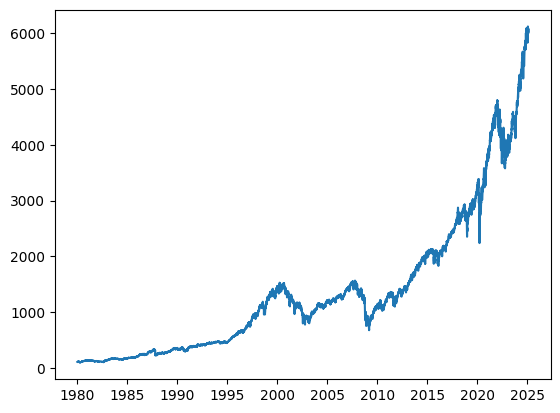

In [94]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [95]:
from copy import deepcopy as dc 

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1980-01-11,109.919998,109.889999,109.050003,108.949997,106.809998,106.519997,105.220001,105.760002
1980-01-14,110.379997,109.919998,109.889999,109.050003,108.949997,106.809998,106.519997,105.220001
1980-01-15,111.139999,110.379997,109.919998,109.889999,109.050003,108.949997,106.809998,106.519997
1980-01-16,111.050003,111.139999,110.379997,109.919998,109.889999,109.050003,108.949997,106.809998
1980-01-17,110.699997,111.050003,111.139999,110.379997,109.919998,109.889999,109.050003,108.949997
...,...,...,...,...,...,...,...,...
2025-02-03,5994.569824,6040.529785,6071.169922,6039.310059,6067.700195,6012.279785,6101.240234,6118.709961
2025-02-04,6037.879883,5994.569824,6040.529785,6071.169922,6039.310059,6067.700195,6012.279785,6101.240234
2025-02-05,6061.479980,6037.879883,5994.569824,6040.529785,6071.169922,6039.310059,6067.700195,6012.279785


In [96]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 109.91999817,  109.88999939,  109.05000305, ...,  106.51999664,
         105.22000122,  105.76000214],
       [ 110.37999725,  109.91999817,  109.88999939, ...,  106.80999756,
         106.51999664,  105.22000122],
       [ 111.13999939,  110.37999725,  109.91999817, ...,  108.94999695,
         106.80999756,  106.51999664],
       ...,
       [6061.47998047, 6037.87988281, 5994.56982422, ..., 6039.31005859,
        6067.70019531, 6012.27978516],
       [6083.56982422, 6061.47998047, 6037.87988281, ..., 6071.16992188,
        6039.31005859, 6067.70019531],
       [6025.99023438, 6083.56982422, 6061.47998047, ..., 6040.52978516,
        6071.16992188, 6039.31005859]])

In [97]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99611327, -0.99612324, -0.99640229, ..., -0.99724275,
        -0.99767461, -0.99749522],
       [-0.99596046, -0.99611327, -0.99612324, ..., -0.99714641,
        -0.99724275, -0.99767461],
       [-0.99570799, -0.99596046, -0.99611327, ..., -0.99643551,
        -0.99714641, -0.99724275],
       ...,
       [ 0.98098826,  0.97314834,  0.95876079, ...,  0.97362344,
         0.98305461,  0.96464402],
       [ 0.98832649,  0.98098826,  0.97314834, ...,  0.98420725,
         0.97362344,  0.98305461],
       [ 0.96919861,  0.98832649,  0.98098826, ...,  0.97402863,
         0.98420725,  0.97362344]])

In [98]:
x = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

x.shape, y.shape

((11363, 7), (11363,))

In [99]:
x = dc(np.flip(x, axis=1))
x

array([[-0.99749522, -0.99767461, -0.99724275, ..., -0.99643551,
        -0.99640229, -0.99612324],
       [-0.99767461, -0.99724275, -0.99714641, ..., -0.99640229,
        -0.99612324, -0.99611327],
       [-0.99724275, -0.99714641, -0.99643551, ..., -0.99612324,
        -0.99611327, -0.99596046],
       ...,
       [ 0.96464402,  0.98305461,  0.97362344, ...,  0.97402863,
         0.95876079,  0.97314834],
       [ 0.98305461,  0.97362344,  0.98420725, ...,  0.95876079,
         0.97314834,  0.98098826],
       [ 0.97362344,  0.98420725,  0.97402863, ...,  0.97314834,
         0.98098826,  0.98832649]])

In [100]:
split_index = int(len(x) * 0.95)
split_index

10794

In [101]:
x_train = x[:split_index]
x_test = x[split_index:]

y_train =y[:split_index]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10794, 7), (569, 7), (10794,), (569,))

In [102]:
x_train = x_train.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10794, 7, 1), (569, 7, 1), (10794, 1), (569, 1))

In [103]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([10794, 7, 1]),
 torch.Size([569, 7, 1]),
 torch.Size([10794, 1]),
 torch.Size([569, 1]))

In [104]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

In [105]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [106]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [107]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [108]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [109]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [110]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.258
Batch 200, Loss: 0.716
Batch 300, Loss: 0.400
Batch 400, Loss: 0.205
Batch 500, Loss: 0.078
Batch 600, Loss: 0.022

Val Loss: 0.101
***************************************************

Epoch: 2
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Batch 600, Loss: 0.001

Val Loss: 0.094
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Batch 600, Loss: 0.000

Val Loss: 0.067
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000

Val Loss: 0.052
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 60

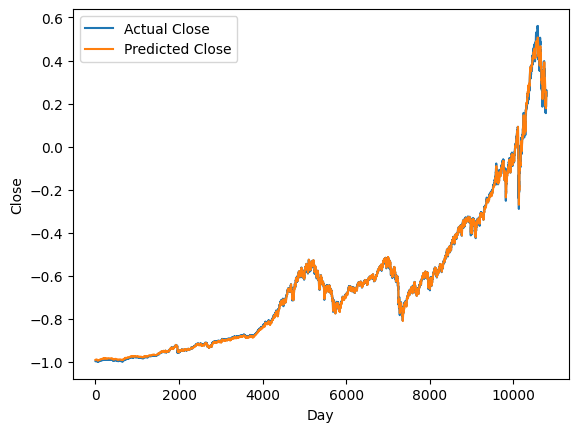

In [111]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [112]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 126.88218119,  127.31890062,  127.68636217, ..., 3828.5991352 ,
       3835.04864154, 3868.2371206 ])

In [113]:
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

/tmp/ipykernel_19028/2743067881.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([ 109.91991941,  110.37996404,  111.14000657, ..., 3807.30004669,
       3901.06006692, 3871.98000711])

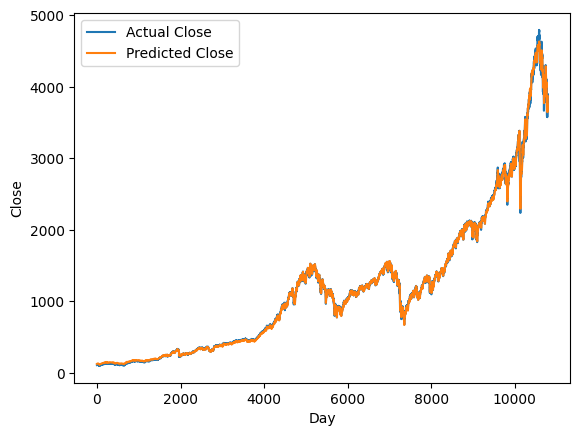

In [114]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [115]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([3889.19660323, 3895.75205978, 3870.77866981, 3836.01071615,
       3827.09147529, 3833.74992156, 3839.5900123 , 3820.97376986,
       3865.17245901, 3915.2962413 , 3945.07049483, 3973.39894507,
       3985.19467599, 3990.40193623, 4005.82024947, 4002.85507882,
       4012.76927385, 4028.82911968, 4038.29547096, 4030.42563962,
       4023.1551761 , 4049.95627459, 4071.68557839, 4083.03436267,
       4070.84066803, 4045.64461215, 4028.55818856, 4025.43306089,
       4009.02728446, 4010.81668583, 4019.47446021, 4022.49848213,
       4000.43087328, 3971.39800213, 3938.50741273, 3916.91178025,
       3914.34762353, 3894.28921116, 3884.54520035, 3877.62443534,
       3861.02909684, 3869.30747795, 3873.6638171 , 3868.72372007,
       3875.82166685, 3867.33551207, 3885.97036981, 3903.01929366,
       3919.21523304, 3945.66600502, 3970.52895916, 3991.98715242,
       4009.41035595, 4001.51980107, 3987.62857045, 3996.79411641,
       4014.90218357, 4026.66211929, 4033.29733007, 4049.67987

In [116]:
dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

/tmp/ipykernel_19028/973696869.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([3856.10007927, 3759.68995795, 3719.8899073 , 3770.55003453,
       3806.80003524, 3828.1101135 , 3748.57007458, 3956.37011678,
       3992.92993889, 3957.25001493, 3991.72994728, 3958.79001612,
       3946.56007772, 3965.34008994, 3949.93989858, 4003.58004384,
       4027.26005171, 4026.12007762, 3963.93995021, 3957.62985677,
       4080.11010082, 4076.5700538 , 4071.69993235, 3998.84009493,
       3941.25996526, 3933.919885  , 3963.51004891, 3934.37983992,
       3990.560099  , 4019.64993746, 3995.32005375, 3895.7499964 ,
       3852.36010841, 3817.65993239, 3821.62010207, 3878.43992007,
       3822.38987838, 3844.82005946, 3829.24999788, 3783.21996687,
       3849.28001631, 3839.49998601, 3824.13989605, 3852.96997257,
       3808.10010091, 3895.08011472, 3892.09009376, 3919.25004141,
       3969.61012587, 3983.16995929, 3999.09012309, 3990.96999446,
       3928.86011177, 3898.85009434, 3972.6101049 , 4019.8100739 ,
       4016.94995634, 4016.21996742, 4060.42991546, 4070.56004

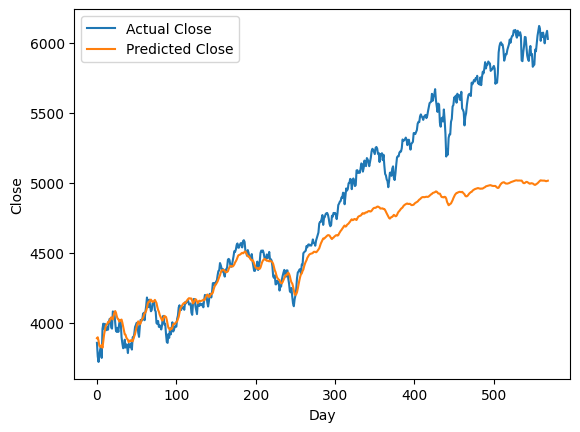

In [117]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()